# Practice Assignment: Understanding Distributions Through Sampling

** *This assignment is optional, and I encourage you to share your solutions with me and your peers in the discussion forums!* **


To complete this assignment, create a code cell that:
* Creates a number of subplots using the `pyplot subplots` or `matplotlib gridspec` functionality.
* Creates an animation, pulling between 100 and 1000 samples from each of the random variables (`x1`, `x2`, `x3`, `x4`) for each plot and plotting this as we did in the lecture on animation.
* **Bonus:** Go above and beyond and "wow" your classmates (and me!) by looking into matplotlib widgets and adding a widget which allows for parameterization of the distributions behind the sampling animations.


Tips:
* Before you start, think about the different ways you can create this visualization to be as interesting and effective as possible.
* Take a look at the histograms below to get an idea of what the random variables look like, as well as their positioning with respect to one another. This is just a guide, so be creative in how you lay things out!
* Try to keep the length of your animation reasonable (roughly between 10 and 30 seconds).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider
from matplotlib.widgets import AxesWidget
import six


%matplotlib notebook

In [2]:
class VertSlider(AxesWidget):
    """
    Vertical Slider Widget written by Ajean. 
    https://stackoverflow.com/questions/25934279/add-a-vertical-slider-with-matplotlib 
    
    A slider representing a floating point range.

    For the slider to remain responsive you must maintain a
    reference to it.

    The following attributes are defined
      *ax*        : the slider :class:`matplotlib.axes.Axes` instance

      *val*       : the current slider value

      *hline*     : a :class:`matplotlib.lines.Line2D` instance
                     representing the initial value of the slider

      *poly*      : A :class:`matplotlib.patches.Polygon` instance
                     which is the slider knob

      *valfmt*    : the format string for formatting the slider text

      *label*     : a :class:`matplotlib.text.Text` instance
                     for the slider label

      *closedmin* : whether the slider is closed on the minimum

      *closedmax* : whether the slider is closed on the maximum

      *slidermin* : another slider - if not *None*, this slider must be
                     greater than *slidermin*

      *slidermax* : another slider - if not *None*, this slider must be
                     less than *slidermax*

      *dragging*  : allow for mouse dragging on slider

    Call :meth:`on_changed` to connect to the slider event
    """
    def __init__(self, ax, label, valmin, valmax, valinit=0.5, valfmt='%1.2f',
                 closedmin=True, closedmax=True, slidermin=None,
                 slidermax=None, dragging=True, **kwargs):
        """
        Create a slider from *valmin* to *valmax* in axes *ax*.

        Additional kwargs are passed on to ``self.poly`` which is the
        :class:`matplotlib.patches.Rectangle` which draws the slider
        knob.  See the :class:`matplotlib.patches.Rectangle` documentation
        valid property names (e.g., *facecolor*, *edgecolor*, *alpha*, ...).

        Parameters
        ----------
        ax : Axes
            The Axes to put the slider in

        label : str
            Slider label

        valmin : float
            The minimum value of the slider

        valmax : float
            The maximum value of the slider

        valinit : float
            The slider initial position

        label : str
            The slider label

        valfmt : str
            Used to format the slider value, fprint format string

        closedmin : bool
            Indicate whether the slider interval is closed on the bottom

        closedmax : bool
            Indicate whether the slider interval is closed on the top

        slidermin : Slider or None
            Do not allow the current slider to have a value less than
            `slidermin`

        slidermax : Slider or None
            Do not allow the current slider to have a value greater than
            `slidermax`


        dragging : bool
            if the slider can be dragged by the mouse

        """
        AxesWidget.__init__(self, ax)

        self.valmin = valmin
        self.valmax = valmax
        self.val = valinit
        self.valinit = valinit
        self.poly = ax.axhspan(valmin, valinit, 0, 1, **kwargs)

        self.hline = ax.axhline(valinit, 0, 1, color='r', lw=1)

        self.valfmt = valfmt
        ax.set_xticks([])
        ax.set_ylim((valmin, valmax))
        ax.set_yticks([])
        ax.set_navigate(False)

        self.connect_event('button_press_event', self._update)
        self.connect_event('button_release_event', self._update)
        if dragging:
            self.connect_event('motion_notify_event', self._update)
        self.label = ax.text(0.5, 1.03, label, transform=ax.transAxes,
                             verticalalignment='center',
                             horizontalalignment='center')

        self.valtext = ax.text(0.5, -0.03, valfmt % valinit,
                               transform=ax.transAxes,
                               verticalalignment='center',
                               horizontalalignment='center')

        self.cnt = 0
        self.observers = {}

        self.closedmin = closedmin
        self.closedmax = closedmax
        self.slidermin = slidermin
        self.slidermax = slidermax
        self.drag_active = False

    def _update(self, event):
        """update the slider position"""
        if self.ignore(event):
            return

        if event.button != 1:
            return

        if event.name == 'button_press_event' and event.inaxes == self.ax:
            self.drag_active = True
            event.canvas.grab_mouse(self.ax)

        if not self.drag_active:
            return

        elif ((event.name == 'button_release_event') or
              (event.name == 'button_press_event' and
               event.inaxes != self.ax)):
            self.drag_active = False
            event.canvas.release_mouse(self.ax)
            return

        val = event.ydata
        if val <= self.valmin:
            if not self.closedmin:
                return
            val = self.valmin
        elif val >= self.valmax:
            if not self.closedmax:
                return
            val = self.valmax

        if self.slidermin is not None and val <= self.slidermin.val:
            if not self.closedmin:
                return
            val = self.slidermin.val

        if self.slidermax is not None and val >= self.slidermax.val:
            if not self.closedmax:
                return
            val = self.slidermax.val

        self.set_val(int(val))

    def set_val(self, val):
        xy = self.poly.xy
        xy[1] = 0, val
        xy[2] = 1, val
        self.poly.xy = xy
        self.valtext.set_text(self.valfmt % val)
        if self.drawon:
            self.ax.figure.canvas.draw_idle()
        self.val = val
        if not self.eventson:
            return
        for cid, func in six.iteritems(self.observers):
            func(val)

    def on_changed(self, func):
        """
        When the slider value is changed, call *func* with the new
        slider position

        A connection id is returned which can be used to disconnect
        """
        cid = self.cnt
        self.observers[cid] = func
        self.cnt += 1
        return cid

    def disconnect(self, cid):
        """remove the observer with connection id *cid*"""
        try:
            del self.observers[cid]
        except KeyError:
            pass

    def reset(self):
        """reset the slider to the initial value if needed"""
        if (self.val != self.valinit):
            self.set_val(self.valinit)

In [3]:
def update_x1(val):
    
    """Update function linked to the x1 Normal Distribution"""
    
    mean = smean[0].val
    subplots[0].cla()
    global x1
    

    
    x1 = np.random.normal(val, 1, 10000)
    avg = x1.mean()
    std = x1.std()
    
    subplots[0].hist(x1, bins=bins1, color='royalblue')
    subplots[0].axvline(mean, linestyle='--',lw=1,color='red')
    subplots[0].axis([max(avg-std*3,x1.min()),min(avg+std*3,x1.max()),0,3000])
    subplots[0].set_title('Normal Distribution')
    
    fig.canvas.draw_idle()

def update_x2(val):
    
    """Update function linked to the x2 Gamma Distribution"""

    mean = smean[1].val
    
    subplots[1].cla()
    global x2
    
    x2 = np.random.gamma(val, 1, 10000)
    avg = x2.mean()
    std = x2.std()
    subplots[1].hist(x2, bins=bins2, color='royalblue')
    subplots[1].axvline(mean, linestyle='--',lw=1,color='red')

    subplots[1].axis([max(avg-std*3,x2.min()),min(avg+std*3,x2.max()),0,3000])
    subplots[1].set_title('Gamma Distribution')
    
    fig.canvas.draw_idle()
    
def update_x3(val):
    
    """Update function linked to the x3 Exponential Distribution"""

    mean = smean[2].val
    
    subplots[2].cla()
    global x3
    
    x3 = np.random.exponential(val, 10000)+7
    avg = x3.mean()
    std = x3.std()
    subplots[2].hist(x3, bins=bins3, color='royalblue')
    subplots[2].axvline(mean, linestyle='--',lw=1,color='red')

    subplots[2].axis([max(avg-std*3,x3.min()),min(avg+std*3,x3.max()),0,3000])
    subplots[2].set_title('Exponential Distribution')
    
    fig.canvas.draw_idle()
    
def update_x4(val):
    
    """Update function for the mean of the x4 Uniform Distribution"""

    val = smean[3].val
    
    subplots[3].cla()
    global x4

    δ = val - x4.mean()
    high, low = x4.max()+δ, x4.min()+δ    
    x4 = np.random.uniform(low, high, size=10000)
    subplots[3].hist(x4, bins=bins4, color='royalblue')
    subplots[3].axvline(x4.mean(), linestyle='--', lw=1, color='red')
    subplots[3].axis([max(x4.mean()-3*x4.std(),x4.min()), min(x4.mean()+3*x4.std(), x4.max()), 0, 2000])
    subplots[3].set_title('Uniform Distribution')
    
    fig.canvas.draw_idle()
    
def update_bins1(val):
    
    """Update function for the number of bins used in the x1 Normal Distribution"""

    global bins1
    bins1 = int(sbins[0].val)
    
    subplots[0].cla()
    
    avg = x1.mean()
    std = x1.std()
    
    subplots[0].hist(x1, bins=bins1, color='royalblue')
    subplots[0].axvline(x1.mean(), linestyle='--',lw=1,color='red')
    subplots[0].axis([max(avg-std*3,x1.min()),min(avg+std*3,x1.max()),0,3000])
    subplots[0].set_title('Normal Distribution')
    
    fig.canvas.draw_idle()

def update_bins2(val):
    global bins2
    bins2 = int(sbins[1].val)
    
    subplots[1].cla()
    
    avg = x2.mean()
    std = x2.std()
    
    subplots[1].hist(x2, bins=bins2, color='royalblue')
    subplots[1].axvline(x2.mean(), linestyle='--',lw=1,color='red')
    subplots[1].axis([max(avg-std*3,x2.min()),min(avg+std*3,x2.max()),0,3000])
    subplots[1].set_title('Gamma Distribution')
    
def update_bins3(val):
    global bins3
    bins3 = int(sbins[2].val)
    
    subplots[2].cla()
    
    avg = x3.mean()
    std = x3.std()
    
    subplots[2].hist(x3, bins=bins3, color='royalblue')
    subplots[2].axvline(x3.mean(), linestyle='--',lw=1,color='red')
    subplots[2].axis([max(avg-std*3,x3.min()),min(avg+std*3,x3.max()),0,3000])
    subplots[2].set_title('Exponential Distribution')
    
def update_bins4(val):
    global bins4
    bins4 = int(sbins[3].val)
    
    subplots[3].cla()
    
    avg = x4.mean()
    std = x4.std()
    
    subplots[3].hist(x4, bins=bins4, color='royalblue')
    subplots[3].axvline(x4.mean(), linestyle='--',lw=1,color='red')
    subplots[3].axis([max(avg-std*3,x4.min()),min(avg+std*3,x4.max()),0,3000])
    subplots[3].set_title('Uniform Distribution')

In [4]:
x1_init_mean = -2.5
x2_init_mean = 2
x3_init_mean = 2
x3_init_mean = .5*(14+20)

x1 = np.random.normal(x1_init_mean, 1, 10000)
x2 = np.random.gamma(x2_init_mean, 1.5, 10000)
x3 = np.random.exponential(x3_init_mean, 10000)+7
x4 = np.random.uniform(14, 20, 10000)

<IPython.core.display.Javascript object>


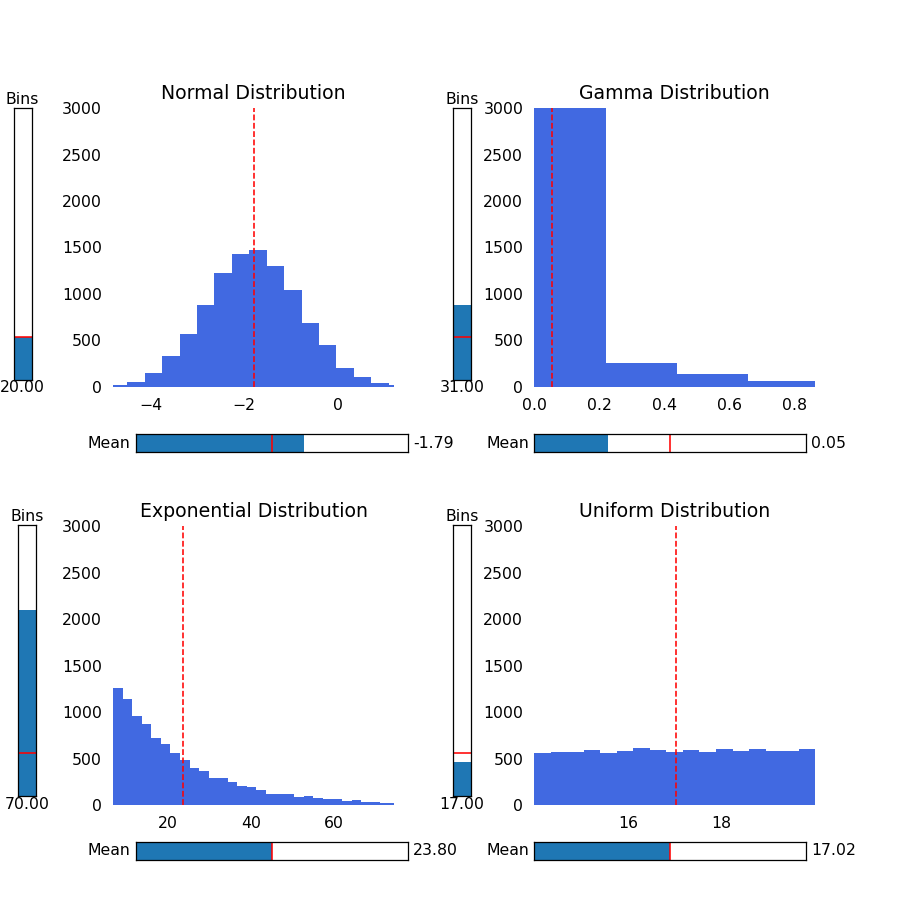

In [5]:
titles = ['Normal', 'Gamma', 'Exponential', 'Uniform']

slider_placement = np.array([[.15,.5,0,0], [.59,.5,0,0], [.15,.05,0,0], [.59,.05,0,0]])
vert_placement = np.array([[.015,.58,0,0], [.50,.58,0,0], [.02,.12,0,0], [.5,.12,0,0]])
data = [x1, x2, x3, x4]
bins, bins1, bins2, bins3, bins4 = 20,20,20,20,20

fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=100)
smean = []
sbins = []

for axis, d, offset, voffset in zip(fig.axes, data, slider_placement, vert_placement):
    slider_width_left, slider_width_right = np.array(axis.get_xlim())*.3
    slider_height_bottom, slider_height_top = np.array(axis.get_ylim())*.02
    
    slider = np.array([slider_width_left, slider_height_bottom, slider_width_right, slider_height_top])
    vert = np.array([slider_height_bottom, slider_width_left, slider_height_top, slider_width_right])
    smean.append(Slider(plt.axes(slider+offset), 
                        'Mean', d.mean()-d.std()*3 , 
                        d.mean()+d.std()*3, valinit=d.mean()))
    sbins.append(VertSlider(plt.axes(vert + voffset),
                           'Bins', 5, 100, valinit=20))
    
smean[1].valmin = 0
smean[2].valmin = 0

subplots = [axis for axis in fig.axes if isinstance(axis, plt.Subplot)]

plt.tick_params(axis='both',
               which='both',
               left=False,
               right=False,
               top=False,
               bottom=False)

plt.subplots_adjust(wspace=.5,
                   hspace=.5)

for axis, d, title in zip(subplots, data, titles):
    avg = d.mean()
    std = d.std()
    axis.hist(d, bins=bins, color='royalblue')
    axis.axis([max(avg-std*3, d.min()), min(avg+std*3, d.max()), 0, 2000])
    axis.axvline(d.mean(),linestyle='--',lw=1,color='red')
    axis.set_title(title + ' Distribution')

    for spine in axis.spines.values():
        spine.set_visible(False)

    axis.tick_params(axis='both',
                    which='both',
                    left=False,
                    right=False,
                    top=False,
                    bottom=False)

smean[0].on_changed(update_x1)
smean[1].on_changed(update_x2)
smean[2].on_changed(update_x3)
smean[3].on_changed(update_x4)
sbins[0].on_changed(update_bins1)
sbins[1].on_changed(update_bins2)
sbins[2].on_changed(update_bins3)
sbins[3].on_changed(update_bins4)

plt.show()
